In [1]:
import os
import gc
import glob
import random
import librosa
import itertools
import IPython.display
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as plt
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from scipy.signal import butter, lfilter
from IPython.display import clear_output
from tensorflow.keras import models, layers, Input
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, LSTM, Dense
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
DATA_type = 'MELS_cnn_1'
Model_name = 'CNN_MELS_1'
Train_data=np.load(f'../Make&stored_DATA/{DATA_type}/Train_data.npy')
Train_lebel=np.load(f'../Make&stored_DATA/{DATA_type}/Train_lebel.npy')
Val_data=np.load(f'../Make&stored_DATA/{DATA_type}/Val_data.npy')
Val_lebel=np.load(f'../Make&stored_DATA/{DATA_type}/Val_lebel.npy')
print(np.shape(Train_data))
print(np.shape(Train_lebel))
print(np.shape(Val_data))
print(np.shape(Val_lebel))

(5, 8000, 256, 4, 1)
(5, 8000)
(5, 2000, 256, 4, 1)
(5, 2000)


In [3]:
class MemoryBestWeights(Callback):
    def __init__(self, monitor='val_loss', mode='min'):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        
        if self.mode == 'min':
            self.best = np.Inf
            self.monitor_op = np.less
        else:
            self.best = -np.Inf
            self.monitor_op = np.greater
        
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:return
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights from {self.monitor} = {self.best:.4f}")
        else:print("No improvement was tracked; model weights not restored.")

class F2Score(Metric):
    def __init__(self, name='f2_score', threshold=0.5, **kwargs):
        super(F2Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.cast(y_pred > self.threshold, 'float32')
        y_true = K.cast(y_true, 'float32')

        tp = K.sum(y_true * y_pred)
        fp = K.sum((1 - y_true) * y_pred)
        fn = K.sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        return 5 * (precision * recall) / (4 * precision + recall + K.epsilon())

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [4]:
os.makedirs("grid_search_outputs", exist_ok=True)

batch_sizes = [16]
learning_rates = [0.0001, 0.0005, 0.001]
hidden_units = [32, 64, 128]
dropouts = [0.05, 0.1]
kernel_regs = [0.005, 0.01]

param_combinations = list(itertools.product(batch_sizes, learning_rates, hidden_units, dropouts, kernel_regs))

results = []
best_model = None
best_model_config_id = None
best_model_recall = 0

for i, (batch_size, lr, hidden_size, dropout_rate, kernel_reg) in enumerate(param_combinations):
    fold_recalls = []
    fold_best_histories = []
    fold_best_cms = []

    for fold in range(5):
        print(f"Running config {i+1}/{len(param_combinations)}")
        print("Config:")
        print(f"  Batch Size     : {batch_size}")
        print(f"  Learning Rate  : {lr}")
        print(f"  Hidden Units   : {hidden_size}")
        print(f"  Dropout Rate   : {dropout_rate}")
        print(f"  Kernel Reg L2  : {kernel_reg}")
        print("-" * 40)
        print(f"Fold : {fold+1}")
        X_train, X_val = Train_data[fold], Train_data[fold]
        y_train, y_val = Train_lebel[fold], Train_lebel[fold]

        tf.keras.backend.clear_session()

        model = models.Sequential([
            Input(shape=np.shape(Train_data[0][0])),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(kernel_reg)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(dropout_rate),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(kernel_reg)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(dropout_rate),
            layers.Flatten(),
            layers.Dense(hidden_size, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=[F2Score(name='f2_score')])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=0)
        memory_best = MemoryBestWeights(monitor='val_recall', mode='max')

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=100,
                            batch_size=batch_size,
                            callbacks=[reduce_lr, memory_best],
                            verbose=1)

        epoch_recalls = []
        for epoch in range(100):
            y_pred = (model.predict(X_val, verbose=0) > 0.5).astype("int32")
            recall = recall_score(y_val, y_pred)
            epoch_recalls.append(recall)

        best_epoch = int(np.argmax(epoch_recalls))
        best_recall = epoch_recalls[best_epoch]

        fold_recalls.append(best_recall)
        fold_best_histories.append(history)
        y_pred = (model.predict(X_val, verbose=0) > 0.5).astype("int32")
        cm = confusion_matrix(y_val, y_pred)
        fold_best_cms.append((cm, y_val, y_pred))
        
        clear_output(wait=True)

    best_fold = int(np.argmax(fold_recalls))
    avg_recall = np.mean(fold_recalls)

    best_history = fold_best_histories[best_fold]
    best_cm, best_y_val, best_y_pred = fold_best_cms[best_fold]

    results.append({
        'config_id': i,
        'batch_size': batch_size,
        'learning_rate': lr,
        'hidden_size': hidden_size,
        'dropout': dropout_rate,
        'kernel_reg': kernel_reg,
        'avg_val_recall': avg_recall,
        'best_fold_recall': fold_recalls[best_fold],
        'history': best_history,
        'confusion_matrix': best_cm
    })

    if avg_recall > best_model_recall:
        best_model_recall = avg_recall
        best_model_config_id = i
        best_model = {
            'history': best_history,
            'confusion_matrix': best_cm
            'model': model
        }

Running config 36/36
Config:
  Batch Size     : 16
  Learning Rate  : 0.001
  Hidden Units   : 128
  Dropout Rate   : 0.1
  Kernel Reg L2  : 0.01
----------------------------------------
Fold : 5
Epoch 1/100
500/500 [==============================] - 3s 6ms/step - loss: 0.5476 - recall: 0.8117 - val_loss: 0.4346 - val_recall: 0.8134 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 3s 5ms/step - loss: 0.4407 - recall: 0.8478 - val_loss: 0.4003 - val_recall: 0.8871 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 3s 6ms/step - loss: 0.4218 - recall: 0.8473 - val_loss: 0.3924 - val_recall: 0.8152 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 3s 6ms/step - loss: 0.4143 - recall: 0.8470 - val_loss: 0.3880 - val_recall: 0.8980 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 3s 6ms/step - loss: 0.4107 - recall: 0.8536 - val_loss: 0.3999 - val_recall: 0.8611 - lr: 0.0010
Epoch 6/100
500/500 [=======================

Best Model Metric
----------------------------------------
Config ID        : 20
Batch Size       : 16
Learning Rate    : 0.001
Hidden Units     : 32
Dropout Rate     : 0.1
Kernel Reg L2    : 0.01
Avg Recall (5-fold): 0.9378
Best Fold Recall : 0.9411
----------------------------------------


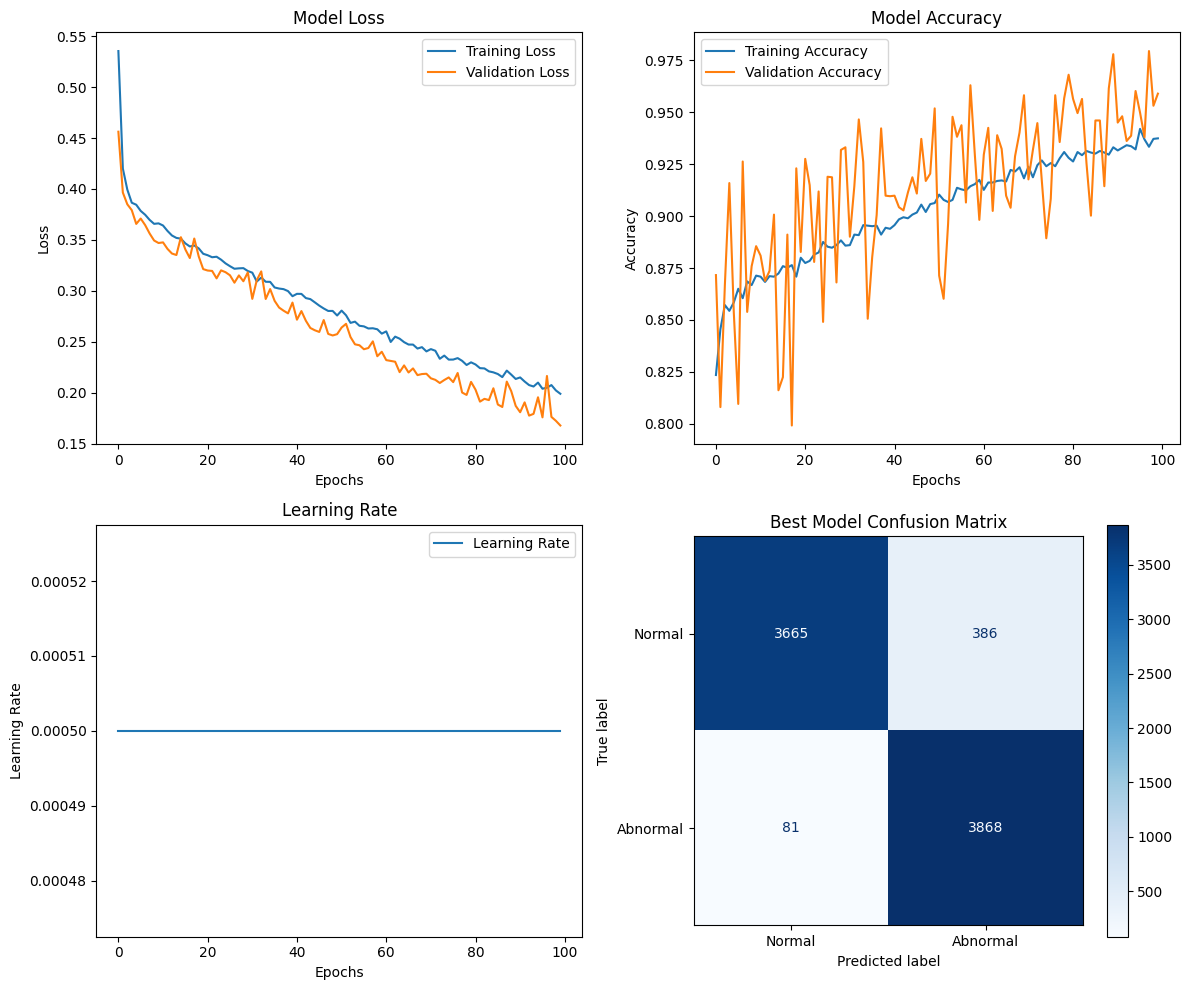

In [7]:
results = sorted(results, key=lambda x: x['avg_val_recall'], reverse=True)

print("Best Model Metric")
print("-" * 40)
print(f"Config ID        : {best_model_config_id}")
print(f"Batch Size       : {results[best_model_config_id]['batch_size']}")
print(f"Learning Rate    : {results[best_model_config_id]['learning_rate']}")
print(f"Hidden Units     : {results[best_model_config_id]['hidden_size']}")
print(f"Dropout Rate     : {results[best_model_config_id]['dropout']}")
print(f"Kernel Reg L2    : {results[best_model_config_id]['kernel_reg']}")
print(f"Avg Recall (5-fold): {results[best_model_config_id]['avg_val_recall']:.4f}")
print(f"Best Fold Recall : {results[best_model_config_id]['best_fold_recall']:.4f}")
print("-" * 40)

best_history = best_model['history']
best_cm = best_model['confusion_matrix']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(best_history.history['loss'], label='Training Loss')
if 'val_loss' in best_history.history:
    axes[0, 0].plot(best_history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

if 'recall' in best_history.history:
    axes[0, 1].plot(best_history.history['recall'], label='Training Accuracy')
if 'val_recall' in best_history.history:
    axes[0, 1].plot(best_history.history['val_recall'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

if 'lr' in best_history.history:
    axes[1, 0].plot(best_history.history['lr'], label='Learning Rate')
elif 'learning_rate' in best_history.history:
    axes[1, 0].plot(best_history.history['learning_rate'], label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].legend()

disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, ax=axes[1, 1])
axes[1, 1].set_title("Best Model Confusion Matrix")

plt.tight_layout()
plt.show()

Best Single-Fold Recall Model
----------------------------------------
Config ID          : 20
Batch Size         : 16
Learning Rate      : 0.0005
Hidden Units       : 128
Dropout Rate       : 0.05
Kernel Reg L2      : 0.005
Best Fold Recall   : 0.9795
----------------------------------------


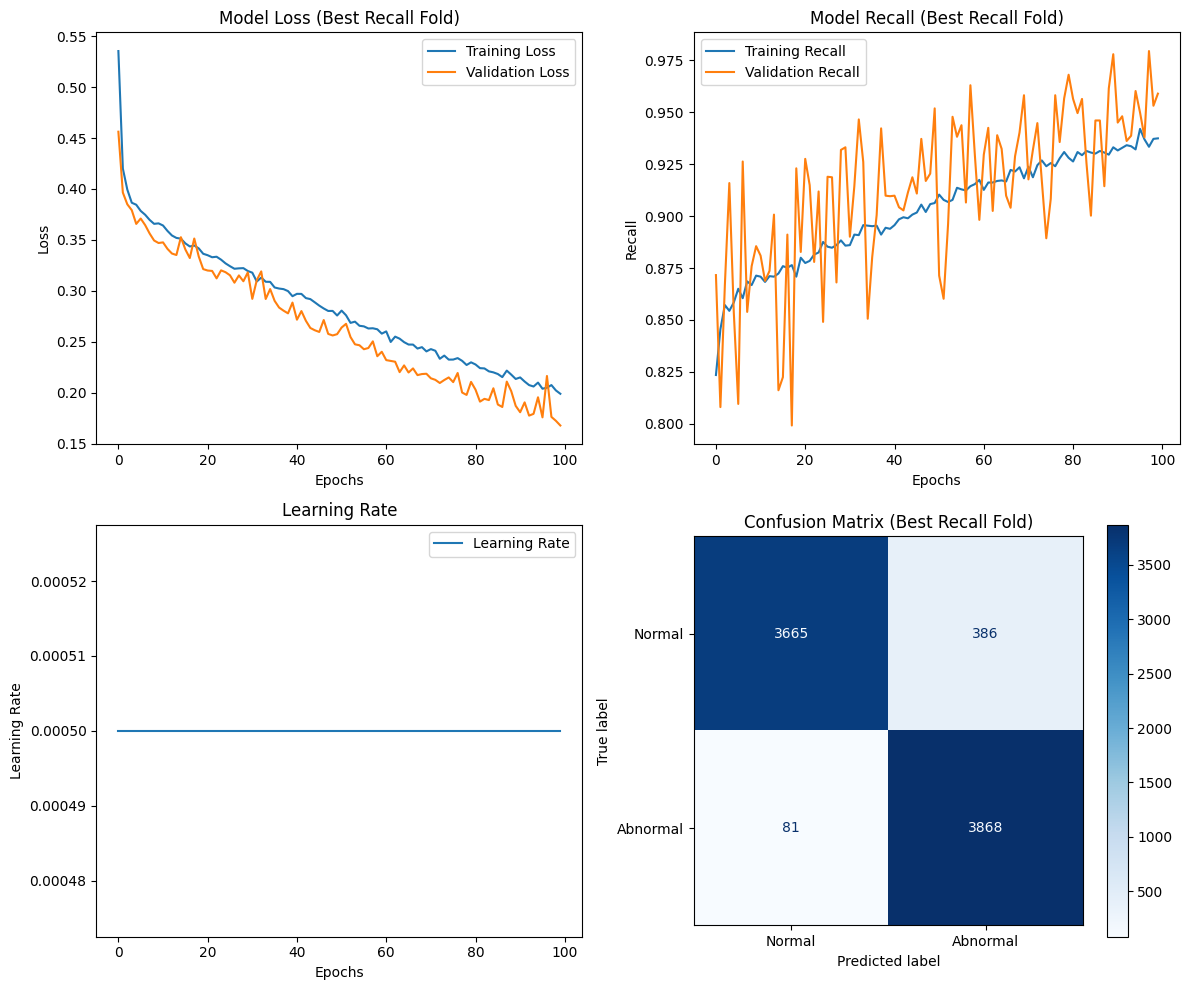

In [9]:
top_best_fold_model = sorted(results, key=lambda x: x['best_fold_recall'], reverse=True)[0]

print("Best Single-Fold Recall Model")
print("-" * 40)
print(f"Config ID          : {top_best_fold_model['config_id']}")
print(f"Batch Size         : {top_best_fold_model['batch_size']}")
print(f"Learning Rate      : {top_best_fold_model['learning_rate']}")
print(f"Hidden Units       : {top_best_fold_model['hidden_size']}")
print(f"Dropout Rate       : {top_best_fold_model['dropout']}")
print(f"Kernel Reg L2      : {top_best_fold_model['kernel_reg']}")
print(f"Best Fold Recall   : {top_best_fold_model['best_fold_recall']:.4f}")
print("-" * 40)

top_best_history = top_best_fold_model['history']
top_best_cm = top_best_fold_model['confusion_matrix']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(top_best_history.history['loss'], label='Training Loss')
if 'val_loss' in top_best_history.history:
    axes[0, 0].plot(top_best_history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss (Best Recall Fold)')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

if 'recall' in top_best_history.history:
    axes[0, 1].plot(top_best_history.history['recall'], label='Training Recall')
if 'val_recall' in top_best_history.history:
    axes[0, 1].plot(top_best_history.history['val_recall'], label='Validation Recall')
axes[0, 1].set_title('Model Recall (Best Recall Fold)')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

if 'lr' in top_best_history.history:
    axes[1, 0].plot(top_best_history.history['lr'], label='Learning Rate')
elif 'learning_rate' in top_best_history.history:
    axes[1, 0].plot(top_best_history.history['learning_rate'], label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].legend()

disp = ConfusionMatrixDisplay(confusion_matrix=top_best_cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix (Best Recall Fold)")

plt.tight_layout()
plt.show()

In [ ]:
best_model['model'].save(f'../new_model/{Model_name}.h5')